In [21]:
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import json
from sim.pymc_util import *

In [2]:
class I:
    Sus = 0
    Inf = 1
    FLat = 2
    SLat = 3
    Rec = 4
    
    N_State_TB = 5

In [42]:
class Model:
    def __init__(self, **exo):
        self.Exo = dict(exo)
    
    def get_y0(self, pars):
        y0 = np.zeros((I.N_State_TB, 2))
        y0[I.Sus] = 0.9
        y0[I.SLat] = 0.1
        y0 /= y0.sum(0)
        y0[:, 0] *= 1 - pars['p_hi']
        y0[:, 1] *= pars['p_hi']
        
        return y0
    
    def calc(self, t, y, pars):
        foi =  pars['beta'] * y[I.Inf].sum() / y.sum()
        
        deaths = pars['r_die'] * y
        births = deaths.sum() * np.array([1 - pars['p_hi'], pars['p_hi']])
        
        rr = np.array([1, pars['rr_act']])
        
        if t < 2025:
            r_acf = 0
        else:
            r_acf = pars['r_acf'] * max(1, (t - 2025) / (2030 - 2025))
        
        return {
            'infection': foi * y[I.Sus],
            'act': rr * pars['r_act'] * y[I.FLat],
            'react': rr * pars['r_react'] * y[I.SLat],
            'rel': pars['r_rel'] * y[I.Rec],
            'lat': pars['r_lat'] * y[I.FLat],
            'rec': pars['r_rec'] * y[I.Inf],
            'acf': r_acf * y[I.Inf],
            'selfcure': pars['r_sc'] * y[I.Inf],
            'deaths': deaths,
            'births': births
        }
    
    def __call__(self, t, y, pars):
        y = y.reshape((I.N_State_TB, 2))
        dy = np.zeros_like(y)
        
        calc = self.calc(t, y, pars)
        
        dy[I.Sus] = calc['births'] - calc['infection']
        dy[I.FLat] = calc['infection'] - calc['act'] - calc['lat']
        dy[I.SLat] = calc['lat'] - calc['react'] + calc['selfcure']
        dy[I.Inf] = calc['act'] + calc['react'] + calc['rel'] - calc['rec'] - calc['acf'] - calc['selfcure']
        dy[I.Rec] = calc['rec'] + calc['acf'] - calc['rel']
        dy -= calc['deaths']
        return dy.reshape(-1)
    
    def measure_full(self, t, y, pars):
        y = y.reshape((I.N_State_TB, 2))
        calc = self.calc(t, y, pars)
        
        prev = y[I.Inf].sum(0) / y.sum(0)
        odds = prev / (1 - prev)
        
        n = y.sum()
        inc = calc['act'] + calc['react'] + calc['rel']
        
        return {
            'Time': t,
            'Prev': y[I.Inf].sum() / n,
            'Prev_Hi': prev[1],
            'Prev_Lo': prev[0],
            'Pr_Hi': y[:, 1].sum() / n,
            'OR_Hi': odds[1] / odds[0],
            'Inc': inc.sum() / n,
            'CNR': (calc['rec'] + calc['acf']).sum() / n,
            'ACF': calc['acf'].sum() / n,
            'Pr_Lat': y[[I.FLat, I.SLat, I.Rec]].sum() / n
        }
    
    def measure_lite(self, t, y, pars):
        y = y.reshape((I.N_State_TB, 2))
        calc = self.calc(t, y, pars)
        
        n = y.sum()
        inc = calc['act'] + calc['react'] + calc['rel']
        
        return {
            'Time': t,
            'Prev': y[I.Inf].sum() / n,
            'Inc': inc.sum() / n,
            'CNR': (calc['rec'] + calc['acf']).sum() / n,
            'Pr_Lat': y[[I.FLat, I.SLat, I.Rec]].sum() / n
        }
    
    def simulate(self, pars, mea_full = True):
        y0 = self.get_y0(pars).reshape(-1)

        ys = solve_ivp(self, [1500, 2020], y0=y0, args=(pars,))
        y1 = ys.y[:, -1]
        
        ys = solve_ivp(self, [2020, 2030], y0=y1, args=(pars,), dense_output=True)
        ts = np.linspace(2020, 2030, 11)
        
        mea = self.measure_full if mea_full else self.measure_lite        
        ms = [mea(t, ys.sol(t), pars) for t in ts]
        
        return ms


<AxesSubplot:xlabel='Time'>

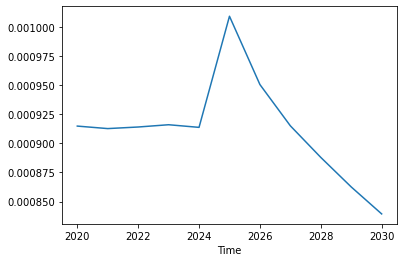

In [44]:
exo = {
    'r_rec': 1,
    'r_act': 0.08,
    'r_react': 0.0001,
    'r_rel': 0.0001,
    'r_lat': 0.5,
    'r_sc': 0.2,
    'r_die': 1 / 70,
    'r_acf': 0.1
}

m = Model(**exo)

p0 = {
    'beta': 15,
    'p_hi': 0.3,
    'rr_act': 1.5,
}
p0.update(m.Exo)

ms = pd.DataFrame(m.simulate(p0, True)).set_index('Time')
ms.CNR.plot()

In [60]:
class Heter(DataModel):
    def __init__(self, obs, eps, simulator):
        DataModel.__init__(self, obs, eps)
        self.Simulator = simulator
    
    def define_prior(self, dm):
        with self.Model:
            beta = pm.Uniform('beta', 5, 100)
            rr_act = pm.Uniform('rr_act', 1, 30)
            p_hi = pm.Uniform('p_hi', 0, 0.5)
            return (beta, p_hi, rr_act)
        
    def complete_pars(self, pars):
        pars = dict(pars)
        pars.update(self.Simulator.Exo)
        return pars
            
    def simulate(self, pars):
        pars = self.complete_pars(pars)
        ms = m.simulate(pars, False)
        return ms[-1]['Inc']
    
    
class HeterFixed(DataModel):
    def __init__(self, obs, eps, simulator, p_hi):
        DataModel.__init__(self, obs, eps)
        self.Simulator = simulator
        self.PrHi = p_hi
    
    def define_prior(self, dm):
        with self.Model:
            beta = pm.Uniform('beta', 5, 100)
            rr_act = pm.Uniform('rr_act', 1, 30)
            return (beta, rr_act)
         
    def complete_pars(self, pars):
        pars = dict(pars)
        pars.update(self.Simulator.Exo)
        pars['p_hi'] = self.PrHi
        return pars
            
    def simulate(self, pars):
        pars = self.complete_pars(pars)
        ms = m.simulate(pars, False)
        return ms[-1]['Inc']
    



In [61]:
m = Model(**exo)
dm = Heter(obs=0.002, eps=0.0002, simulator = m)

with dm.Model:
    pprior = pm.sample_prior_predictive(100)
    fit = pm.sample_smc(draws=200, cores=3)
    ppost = pm.sample_posterior_predictive(fit)

Initializing SMC sampler...
Sampling 3 chains in 3 jobs


We recommend running at least 4 chains for robust computation of convergence diagnostics


(array([  2.,  26.,  66., 145., 158., 118.,  58.,  22.,   4.,   1.]),
 array([0.00142057, 0.00154949, 0.00167842, 0.00180735, 0.00193628,
        0.0020652 , 0.00219413, 0.00232306, 0.00245198, 0.00258091,
        0.00270984]),
 <BarContainer object of 10 artists>)

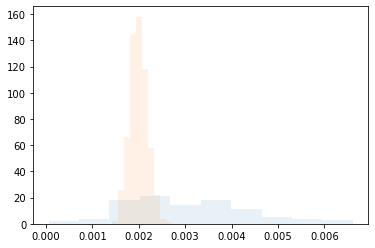

In [62]:
plt.hist(pprior.prior_predictive.stack(samples=('draw', 'chain'))['sim'], alpha = 0.1)
plt.hist(ppost.posterior_predictive.stack(samples=('draw', 'chain'))['sim'], alpha=0.1)

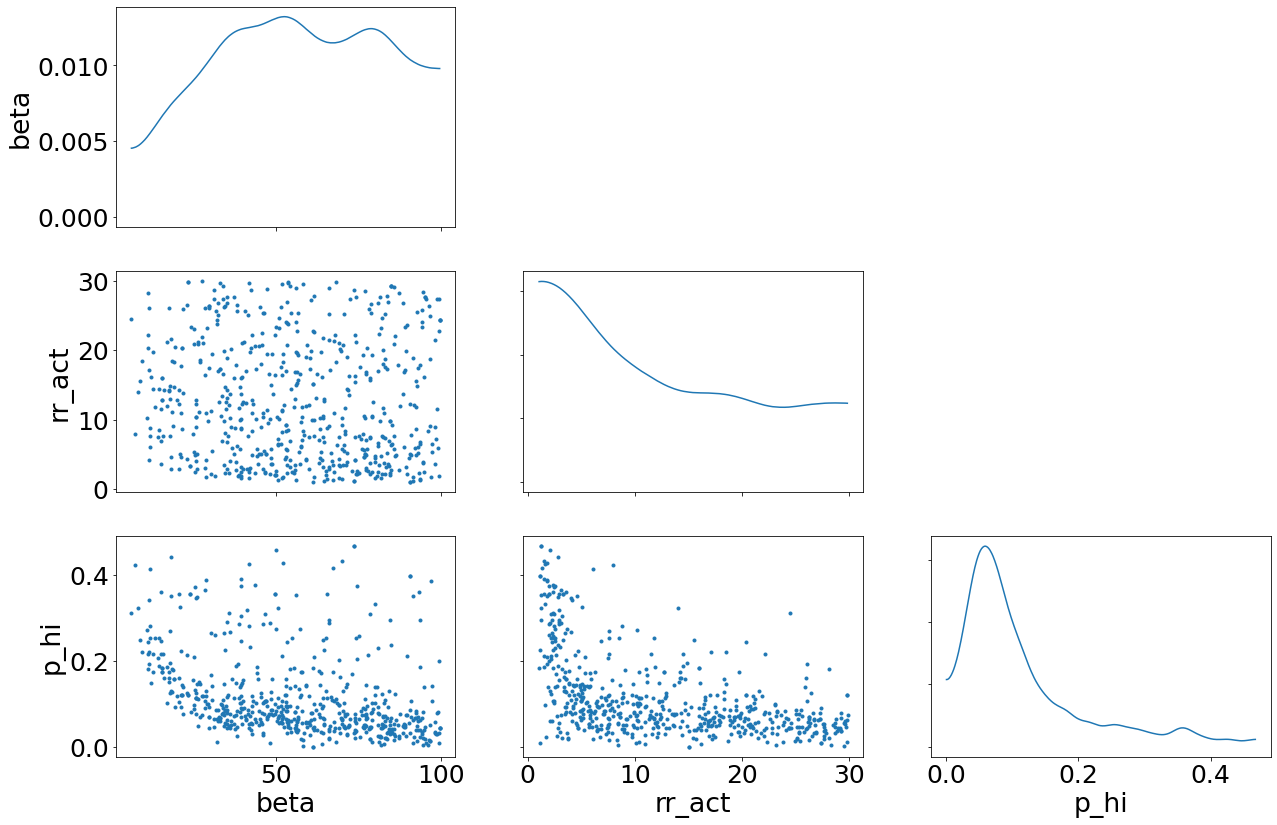

In [63]:
az.plot_pair(
    fit,
    kind="scatter",
    textsize=25,
    marginals=True,
),
figsize = (10, 10)

In [64]:
dm1 = HeterFixed(obs=0.002, eps=0.0002, simulator = m, p_hi=0.1)

with dm1.Model:
    fit1 = pm.sample_smc(draws=200, cores=3)
    ppost1 = pm.sample_posterior_predictive(fit1)

dm3 = HeterFixed(obs=0.002, eps=0.0002, simulator = m, p_hi=0.3)

with dm3.Model:
    fit3 = pm.sample_smc(draws=200, cores=3)
    ppost3 = pm.sample_posterior_predictive(fit1)

Initializing SMC sampler...
Sampling 3 chains in 3 jobs


/opt/conda/envs/pymc-dev/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (3) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
We recommend running at least 4 chains for robust computation of convergence diagnostics


Initializing SMC sampler...
Sampling 3 chains in 3 jobs


We recommend running at least 4 chains for robust computation of convergence diagnostics


In [71]:
sims = [dm.complete_pars(pt) for pt in post_to_particles(fit)[:500]]
sims1 = [dm1.complete_pars(pt) for pt in post_to_particles(fit1)[:500]]
sims3 = [dm3.complete_pars(pt) for pt in post_to_particles(fit3)[:500]]


In [72]:
with open('out/test/sims_free.json', 'w') as f:
    json.dump(sims, f)
    
with open('out/test/sims_10%.json', 'w') as f:
    json.dump(sims1, f)
    
with open('out/test/sims_30%.json', 'w') as f:
    json.dump(sims3, f)